In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from indoorgml.map import Map
from indoorgml.dcel import DCEL, Chain
from indoorgml.navigation import navigation_layer, from_layer, obstacle
from indoorgml.convex_partition import APolygon, partition
from indoorgml.display.svg import svg_for_dcel
from indoorgml.display import jupyter
from IPython.display import SVG
from shapely.ops import cascaded_union
from shapely.geometry import LineString, Polygon, Point
from shapely.affinity import translate
from matplotlib import pyplot as plt
from indoorgml.display.plt import plot, plot_graph

# Import a map

In [3]:
map_ = Map.from_file('../example/map.xml')
# map_ = Map.from_file('../example/idsia.xml')

In [4]:
print(f"""{map_} is composed of several layers:
{[repr(l) for l in map_.layers.values()]}"""
     )

MultiLayeredGraph: IndoorMap is composed of several layers:
['SpaceLayer: L0', 'SpaceLayer: L1', 'SpaceLayer: L2', 'SpaceLayer: L3', 'SpaceLayer: W']


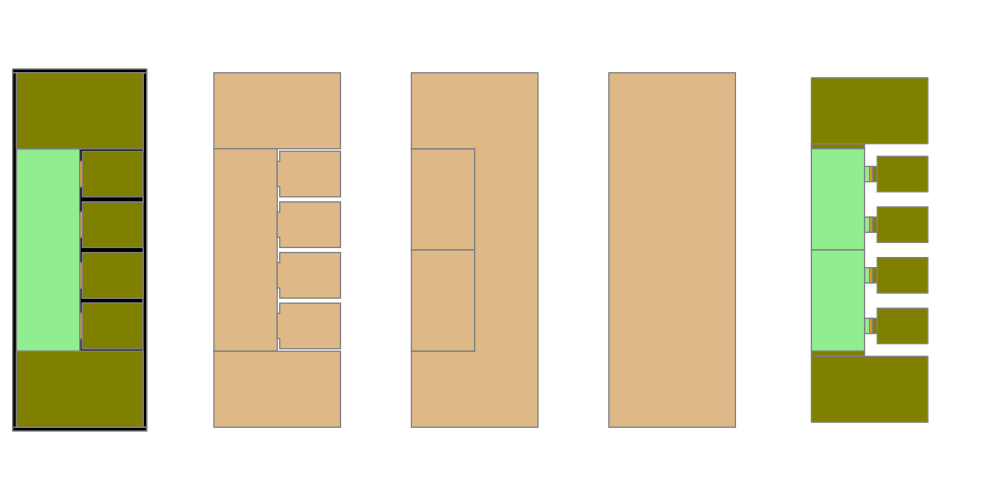

In [5]:
map_

SpaceLayer: L0 is a TOPOGRAPHIC layer for Geometry


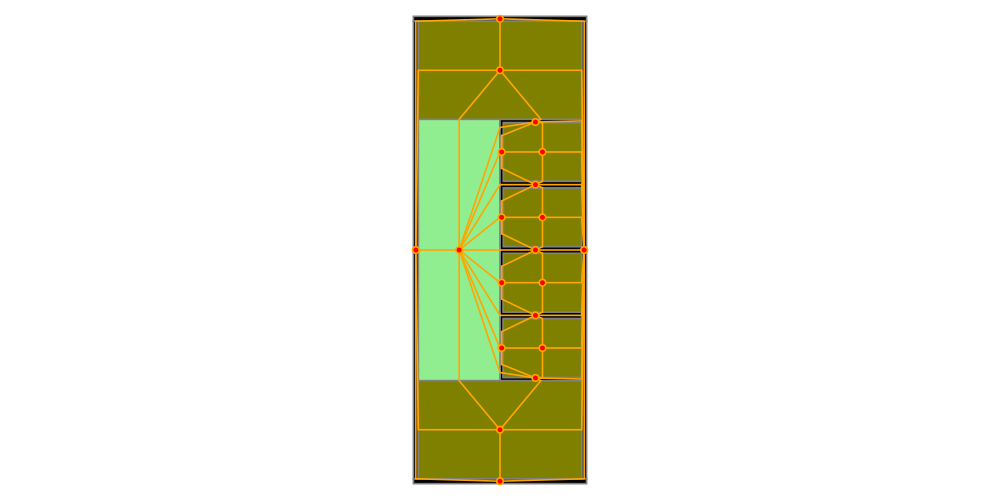

In [6]:
layer = map_['L0']
print(f"""{layer} is a {layer.cls_name} layer for {layer.usage}""")
layer

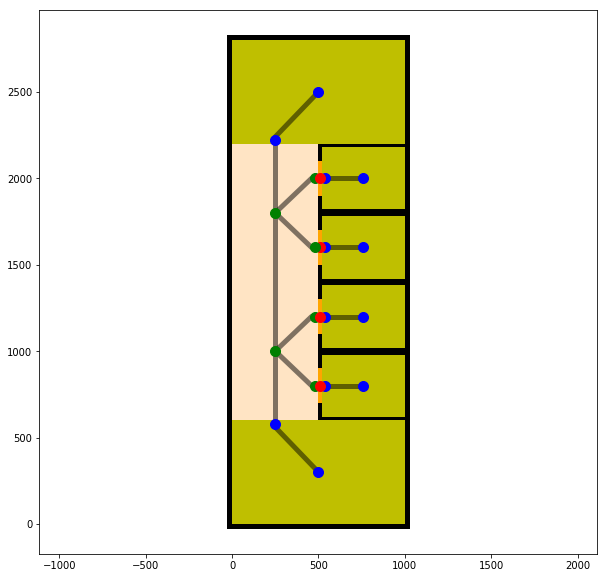

In [7]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
def color(gml):
    if gml.duality.type == 'ConnectionSpace':
        return 'r', 1
    if gml.duality.type == 'TransitionSpace':
        return 'g', 1
    if gml.duality.type == 'GeneralSpace':
        return 'b', 1
    if gml.type == 'Transition':
        return 'k', 0.5
    else:
        return 'k', 1
plot(map_['L0'], ax)
plot_graph(map_['W'], ax, color=color)

A layer is a graph states (linked to cells) with transitions (edge) between them (linked to common boundaries)

In [8]:
state = layer.states['L0S1']
neighbors = '\n'.join(f"{s} via {state.transitionsTo(s)[0]}" for s in state.neighbors)
print(f"{state} is linked to cell {state.duality};")
print(f"and is connected to:\n{neighbors}""")

State: L0S1 is linked to cell TransitionSpace: L0C1;
and is connected to:
State: L0S13 via Transition: L0T12
State: L0S11 via Transition: L0T10
State: L0S12 via Transition: L0T11
State: L0S9 via Transition: L0T8
State: L0S10 via Transition: L0T9
State: L0S5 via Transition: L0T4
State: L0S6 via Transition: L0T5
State: L0S7 via Transition: L0T6
State: L0S8 via Transition: L0T7
State: L0S2 via Transition: L0T1
State: L0S3 via Transition: L0T2
State: L0S4 via Transition: L0T3


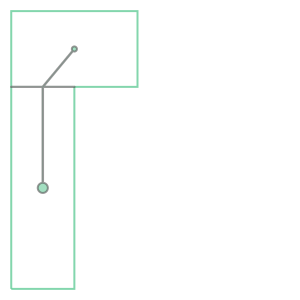

In [9]:
next_state = layer.states['L0S4']
transition = state.transitionsTo(next_state)[0]
cascaded_union([state.geometry.buffer(40), next_state.geometry.buffer(20), transition.geometry.buffer(2),
                transition.duality.geometry.buffer(1), state.duality.geometry.boundary, 
                next_state.duality.geometry.boundary])

Its dual TransitionSpace: L0C1 is a Horizontal Transition (1000) (a Corridor (1000)) with polygonian shape POLYGON ((0 600, 0 2200, 500 2200, 500 2100, 500 1900, 500 1700, 500 1500, 500 1300, 500 1100, 500 900, 500 700, 500 600, 0 600)) and several boundaries {NavigableBoundary: L0B7, CellSpaceBoundary: L0B10, NavigableBoundary: L0B11, CellSpaceBoundary: L0B6, CellSpaceBoundary: L0B4, CellSpaceBoundary: L0B12, NavigableBoundary: L0B3, CellSpaceBoundary: L0B2, CellSpaceBoundary: L0B8, NavigableBoundary: L0B5, NavigableBoundary: L0B1, NavigableBoundary: L0B9}


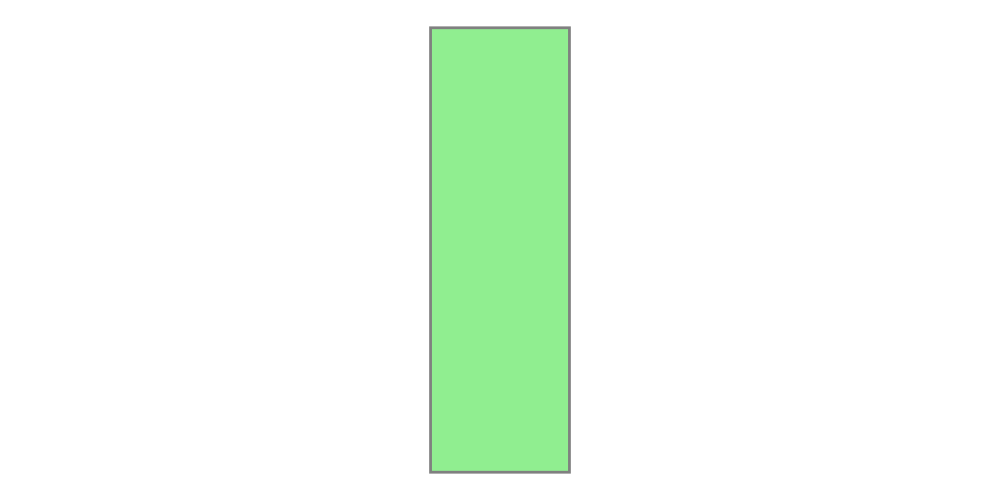

In [10]:
cell = state.duality
print(f"Its dual {cell} is a {cell.cls_name} (a {cell.function}) with polygonian shape {cell.geometry}" 
      f" and several boundaries {cell.boundary}")
cell

The full specifications are given by the indoorGML XML format (similar to the other entities)

In [11]:
jupyter.xml(cell.xml())

# Spatial queries

## States in box

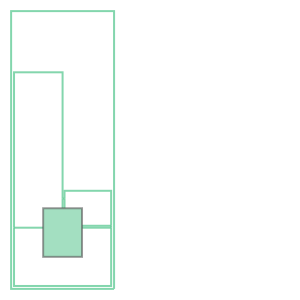

In [12]:
bb = min_x, min_y, max_x, max_y = (300, 300, 700, 800)
box = Polygon([(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y)])

states = layer.states_crossing_box(bb)
cascaded_union([layer.geometry.boundary, box] + [s.duality.geometry.boundary for s in states])

## State with point

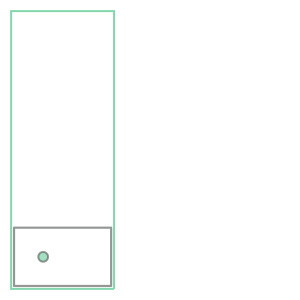

In [13]:
p = (300, 300)
state = layer.state_at(p)
cascaded_union([layer.geometry.boundary, Point(p).buffer(50), state.duality.geometry.boundary.buffer(1)])

## State near point

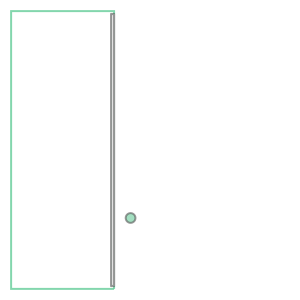

In [14]:
p = (1200, 700)
state = layer.nearest_state_among(p)
cascaded_union([layer.geometry.boundary, Point(p).buffer(50), state.duality.geometry.boundary.buffer(1)])

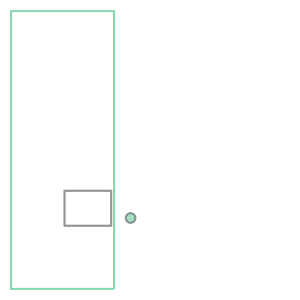

In [15]:
p = (1200, 700)
state = layer.nearest_state_among(p, states_with=lambda s: s.duality.type == 'GeneralSpace')
cascaded_union([layer.geometry.boundary, Point(p).buffer(50), state.duality.geometry.boundary.buffer(1)])

# DCEL

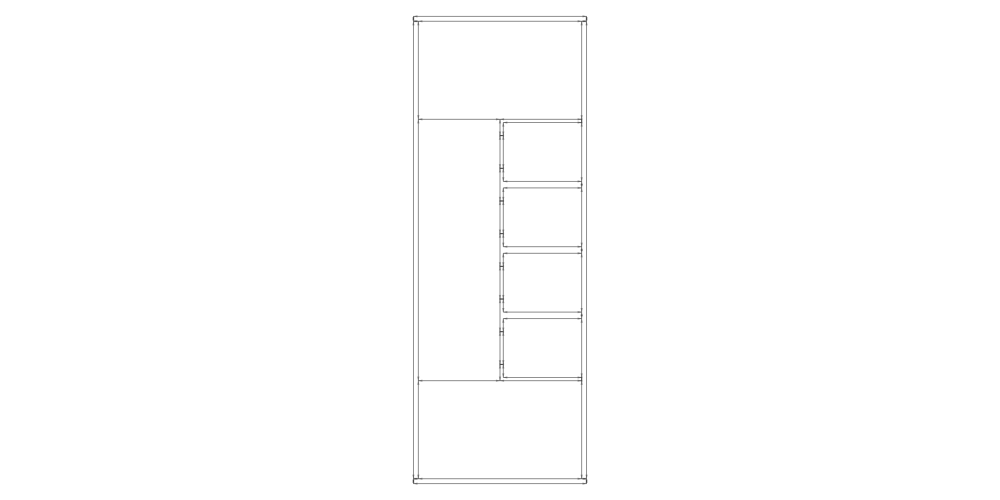

In [16]:
dcel = DCEL(layer)
SVG(svg_for_dcel(dcel))

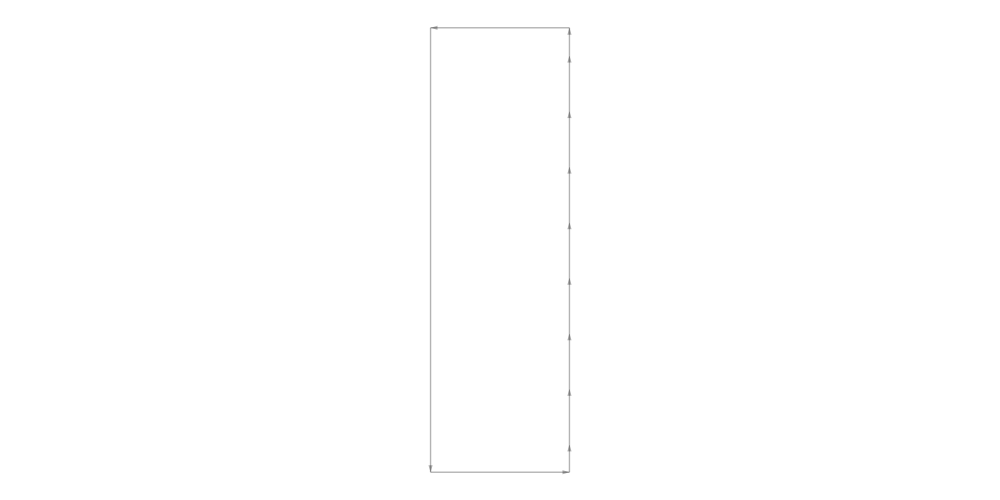

In [17]:
SVG(svg_for_dcel(Chain.loop(dcel.outer_edge[cell])))

Dcel edges have a link to their face (an indoorGML cell) and to the indoorGML boundary + they usual attibutes

In [18]:
edge = dcel.outer_edge[cell]

In [19]:
print(f'{edge} has face {edge.face} and in part of {edge.face_boundary}: next {edge.next}, origin {edge.origin}, twin {edge.twin}')

LINESTRING (500 1700, 500 1900) has face TransitionSpace: L0C1 and in part of CellSpaceBoundary: L0B6: next LINESTRING (500 1900, 500 2100), origin POINT (500 1700), twin LINESTRING (500 1900, 500 1700)


In [20]:
print(f'Twin edges {edge} and {edge.twin} belong to the same indoorGML boundary ({edge.face_boundary == edge.twin.face_boundary})')

Twin edges LINESTRING (500 1700, 500 1900) and LINESTRING (500 1900, 500 1700) belong to the same indoorGML boundary (True)


# Derivation of a new navigation layer

We can derive a new layer as a copy of a layer minus obstacles (walls) with a clearance

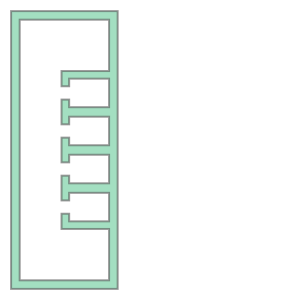

In [21]:
obstacle(map_['L0'],clearance=30 )

In [22]:
new_layer = from_layer(map_['L0'], uid='N', clearance=30, intersect=[], convex=False)

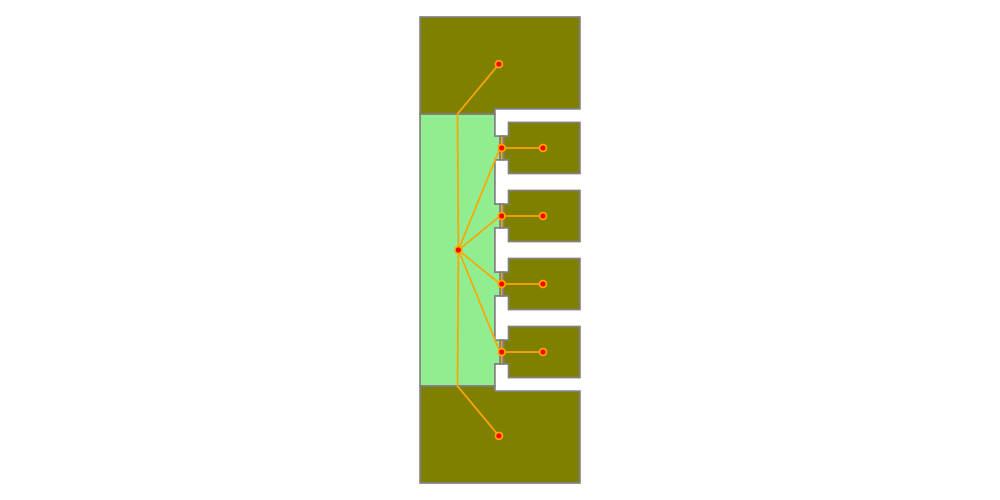

In [23]:
new_layer

such that the new cells are contained in one cell for evry layer in `intersect`


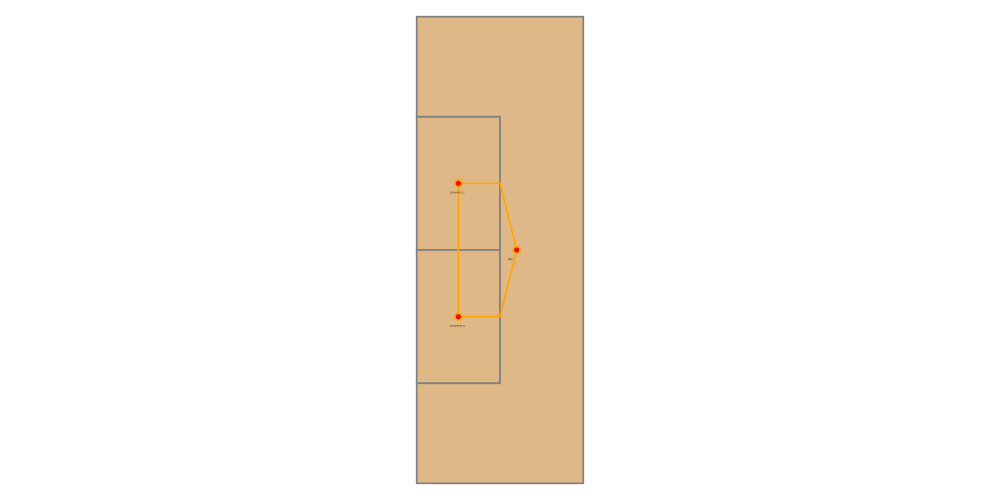

In [24]:
map_["L2"]

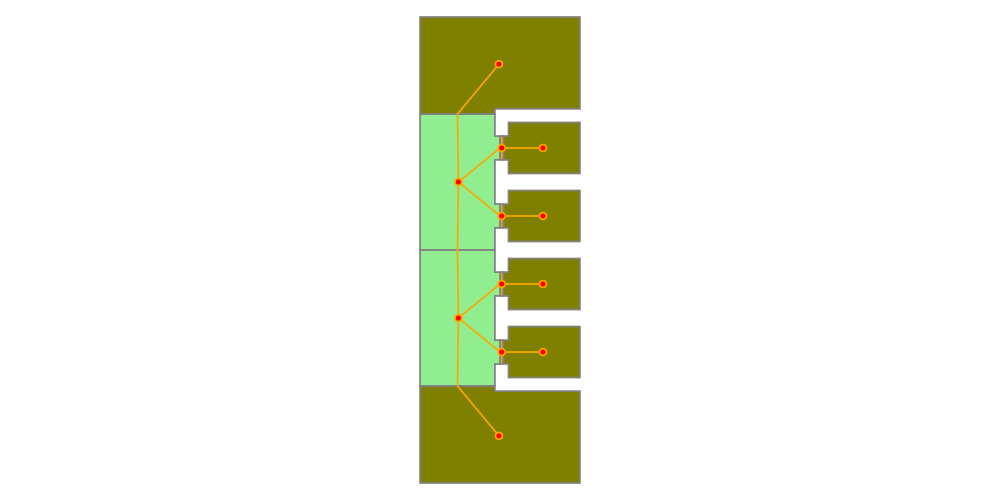

In [25]:
from_layer(map_['L0'], uid='N', clearance=30, intersect=[map_["L2"]], convex=False)

and such that all cells are (quasi) convex 

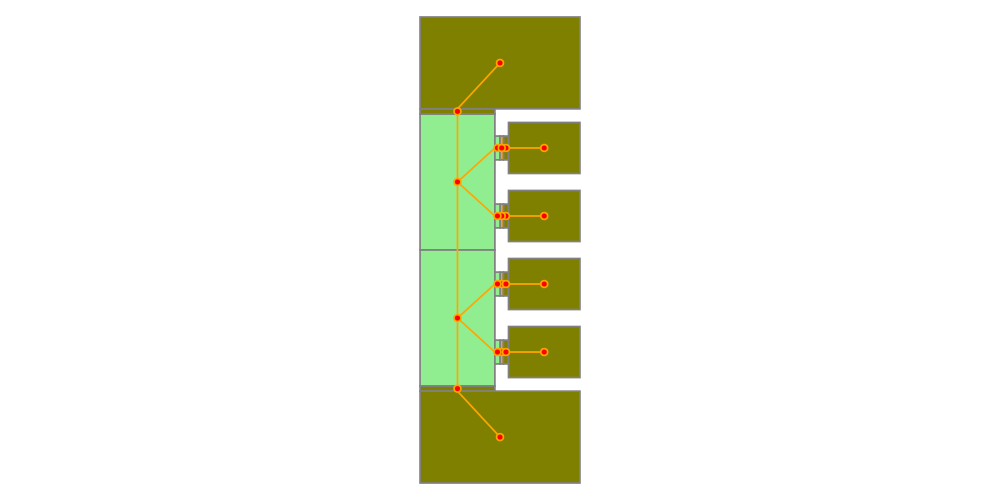

In [26]:
from_layer(map_['L0'], uid='N', clearance=30, intersect=[map_["L2"]], convex=True)

This process is automatized by copyng the geometric layer and intersecting with any (non topographic) layer

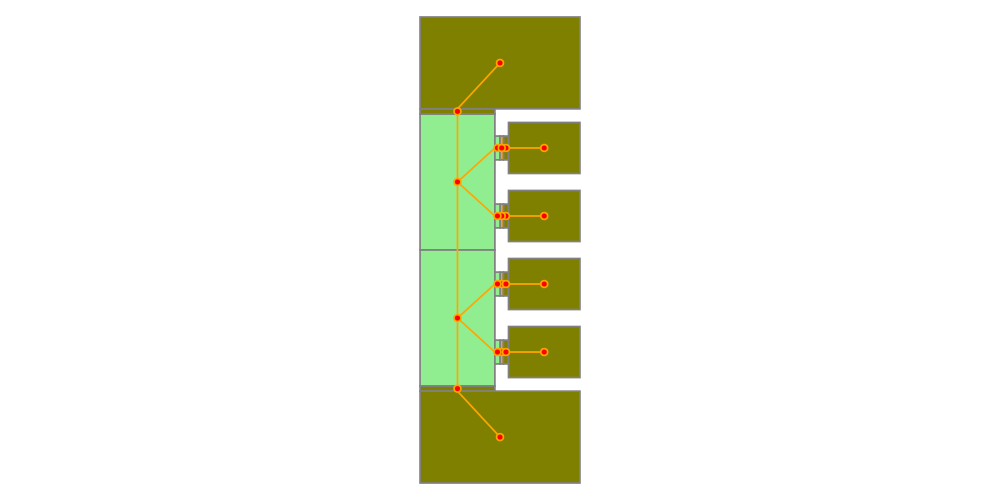

In [27]:
navigation_layer(map_, uid='NAV', clearance=30)

## Convex decomposition

In [28]:
source = Polygon([(0,0), (1.5, 0), (1.5,1), (2,1), (2,3),(1,3),(1,2), (0,2)], [[(0.5,0.5),(0.5,1),(1,1),(1,0.5)]])

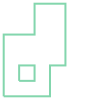

In [29]:
source.boundary

In [30]:
p = APolygon(source)

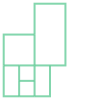

In [31]:
cascaded_union([x.source.exterior for x in p.partition])

At first, we cut along the shortest diagonals to split the polygon in polygons without holes

In [32]:
diagonal = p.best_diagonal
ps = p.split(diagonal)

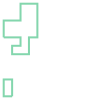

In [33]:
cascaded_union([translate(x.source.exterior, yoff=2.5*i) for i, x in enumerate(list(ps))])

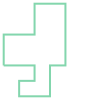

In [34]:
p = ps[1]
p.source.exterior

The we cut until the polygon is not convex

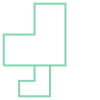

In [35]:
diagonal = p.best_diagonal
cascaded_union([p.source.boundary, diagonal])

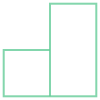

In [36]:
ps = p.split(diagonal)
p = ps[0]
diagonal = p.best_diagonal
cascaded_union([p.source.boundary, diagonal])